In [1]:
%pylab inline
import numpy as np
import scipy as sp
import tensorflow as tf
import pandas as pd
import seaborn as sns
import itertools,time
import sys, os
from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import itertools
import pickle

Populating the interactive namespace from numpy and matplotlib


/afs/inf.ed.ac.uk/group/cup/data1/akash_itm/IPC_MAP/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)
def log_dir_init(fan_in, fan_out,topics=50): 
    return tf.log((1.0/topics)*tf.ones([fan_in, fan_out]))

tf.reset_default_graph()
class VariationalAutoencoder(object):
    """ 
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        print 'Learning Rate:', self.learning_rate
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        self.keep_prob = tf.placeholder(tf.float32)
        
        self.h_dim = float(network_architecture["n_z"])
        self.a0 = np.ones((1 , 2)).astype(np.float32)
        self.a1 = np.ones((1 , self.h_dim)).astype(np.float32)*10
        self.a2 = np.ones((1 , self.h_dim)).astype(np.float32)/200.0#(10*self.h_dim)
        
        self.mu2a0 = tf.constant((np.log(self.a0).T-np.mean(np.log(self.a0),1)).T)
        self.var2a0 = tf.constant(  ( ( (1.0/self.a0)*( 1 - (2.0/2.0) ) ).T +
                                ( 1.0/(self.h_dim*self.h_dim) )*np.sum(1.0/self.a0,1) ).T  )
        
        self.mu2a1 = tf.constant((np.log(self.a1).T-np.mean(np.log(self.a1),1)).T)
        self.var2a1 = tf.constant(  ( ( (1.0/self.a1)*( 1 - (2.0/self.h_dim) ) ).T +
                                ( 1.0/(self.h_dim*self.h_dim) )*np.sum(1.0/self.a1,1) ).T  )
        
        self.mu2a2 = tf.constant((np.log(self.a2).T-np.mean(np.log(self.a2),1)).T)
        self.var2a2 = tf.constant(  ( ( (1.0/self.a2)*( 1 - (2.0/self.h_dim) ) ).T +
                                ( 1.0/(self.h_dim*self.h_dim) )*np.sum(1.0/self.a2,1) ).T  )
        
        
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = self._initialize_weights(**self.network_architecture)
        '''Adding 2 subtopics and 1 super topic.'''
        self.z_mean0,self.z_log_sigma_sq0 = \
            self._recognition_network(self.network_weights["weights_recog"], 
                                      self.network_weights["biases_recog"])
            
        self.z_mean1,self.z_log_sigma_sq1 = \
            self._recognition_network(self.network_weights["sub_01"], 
                                      self.network_weights["biases_sub_01"])
        
        self.z_mean2,self.z_log_sigma_sq2 = \
            self._recognition_network(self.network_weights["sub_01"], 
                                      self.network_weights["biases_sub_01"])

        # Draw one sample z from Gaussian distribution
        '''Adding another noise variable for super toipc: hard coding atm'''
        eps0 = tf.random_normal((1, 2), 0, 1, 
                               dtype=tf.float32)
        n_z = self.network_architecture["n_z"]
        eps1 = tf.random_normal((1, n_z), 0, 1, 
                               dtype=tf.float32)
        eps2 = tf.random_normal((1, n_z), 0, 1, 
                               dtype=tf.float32)
        '''Adding RT for subtopics'''
        self.z0 = tf.nn.softmax(tf.contrib.layers.batch_norm(tf.add(self.z_mean0, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq0)), eps0))))
        self.sigma0 = tf.exp(self.z_log_sigma_sq0)
        
        self.z1 = tf.add(self.z_mean1, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq1)), eps1))
        self.sigma1 = tf.exp(self.z_log_sigma_sq1)
        
        self.z2 = tf.add(self.z_mean2, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq2)), eps2))
        self.sigma2 = tf.exp(self.z_log_sigma_sq2)
        
        '''Adding subtopic reconstruction'''
            
#         self.theta = tf.matmul(self.z0,tf.concat(0,[self.z1, self.z2]))
        
        self.theta = tf.squeeze(tf.map_fn(lambda i: 
                                          tf.matmul(tf.expand_dims(tf.gather(self.z0,i),0),
                                                    tf.concat(0,[tf.expand_dims(tf.gather(self.z1,i),0),
                                                                tf.expand_dims(tf.gather(self.z2,i),0)])),
                                                   tf.constant(np.arange(self.batch_size)), dtype=tf.float32))
            
        self.x_reconstr_mean0,self.x_reconstr_mean1,self.x_reconstr_mean2 = \
            self._generator_network(tf.nn.dropout(self.theta, self.keep_prob),self.z1,self.z2,
                                    self.network_weights["weights_gener"],
                                    self.network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  
                            n_input, n_z):
        all_weights = dict()
        with tf.variable_scope("super"):
            all_weights['weights_recog'] = {
                'h1': tf.get_variable('h1',[n_input, n_hidden_recog_1]),
                'h2': tf.get_variable('h2',[n_hidden_recog_1, n_hidden_recog_2]),
                'out_mean': tf.get_variable('out_mean',[n_hidden_recog_2, 2]),
                'out_log_sigma': tf.get_variable('out_log_sigma',[n_hidden_recog_2, 2])
            }
            all_weights['biases_recog'] = {
                'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
                'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
                'out_mean': tf.Variable(tf.zeros([2], dtype=tf.float32)),
                'out_log_sigma': tf.Variable(tf.zeros([2], dtype=tf.float32))
            }
        with tf.variable_scope("sub01"):
            all_weights['sub_01'] = {
                'h1': tf.get_variable('h1',[n_input, n_hidden_recog_1]),
                'h2': tf.get_variable('h2',[n_hidden_recog_1, n_hidden_recog_2]),
                'out_mean': tf.get_variable('out_mean',[n_hidden_recog_2, n_z]),
                'out_log_sigma': tf.get_variable('out_log_sigma',[n_hidden_recog_2, n_z])}
            all_weights['biases_sub_01'] = {
                'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
                'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
                'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
                'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))
            }
        with tf.variable_scope("sub02"):
            all_weights['sub_02'] = {
                'h1': tf.get_variable('h1',[n_input, n_hidden_recog_1]),
                'h2': tf.get_variable('h2',[n_hidden_recog_1, n_hidden_recog_2]),
                'out_mean': tf.get_variable('out_mean',[n_hidden_recog_2, n_z]),
                'out_log_sigma': tf.get_variable('out_log_sigma',[n_hidden_recog_2, n_z])
            }
            all_weights['biases_sub_02'] = {
                'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
                'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
                'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
                'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))
            }
        with tf.variable_scope("gen"):
            all_weights['weights_gener'] = {
                'h0': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
                'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
                'h2': tf.Variable(xavier_init(n_z, n_hidden_gener_1))
            }
            all_weights['biases_gener'] = {
                'b0': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
                'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
                'b2': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32))
            }
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network)
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_do = tf.nn.dropout(layer_2, self.keep_prob)
        
        z_mean = tf.contrib.layers.batch_norm(tf.add(tf.matmul(layer_do, weights['out_mean']),
                        biases['out_mean']))
        z_log_sigma_sq = \
            tf.contrib.layers.batch_norm(tf.add(tf.matmul(layer_do, weights['out_log_sigma']), 
                   biases['out_log_sigma']))     
        
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self,z0,z1,z2, weights, biases):
        # Generate probabilistic decoder (decoder network)
        self.layer_do_0 = tf.nn.dropout(tf.nn.softmax(tf.contrib.layers.batch_norm(z0)), self.keep_prob)
        self.layer_do_1 = tf.nn.dropout(tf.nn.softmax(tf.contrib.layers.batch_norm(z1)), self.keep_prob)
        self.layer_do_2 = tf.nn.dropout(tf.nn.softmax(tf.contrib.layers.batch_norm(z2)), self.keep_prob)
#         x_reconstr_mean = tf.add(tf.matmul(self.layer_do_0, 
#                                            tf.nn.softmax(tf.contrib.layers.batch_norm(weights['h2']))),0.0)
        x_reconstr_mean0 = tf.nn.softmax(tf.contrib.layers.batch_norm(tf.add(
                    tf.matmul(self.layer_do_0, weights['h2']),0.0)))
        x_reconstr_mean1 = tf.nn.softmax(tf.contrib.layers.batch_norm(tf.add(
                        tf.matmul(self.layer_do_1, weights['h0']),0.0)))
        x_reconstr_mean2 = tf.nn.softmax(tf.contrib.layers.batch_norm(tf.add(
                        tf.matmul(self.layer_do_2, weights['h1']),0.0)))
    
        return x_reconstr_mean0,x_reconstr_mean1,x_reconstr_mean2

            
    def _create_loss_optimizer(self):
        
        self.x_reconstr_mean0+=1e-10
        self.x_reconstr_mean1+=1e-10
        self.x_reconstr_mean2+=1e-10
     
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(self.x_reconstr_mean0),1)+\
            -tf.reduce_sum(self.x * tf.log(self.x_reconstr_mean1),1)+\
            -tf.reduce_sum(self.x * tf.log(self.x_reconstr_mean2),1)

    
        latent_loss0 = 0.5*( tf.reduce_sum(tf.div(self.sigma0,self.var2a0),1)+\
        tf.reduce_sum( tf.mul(tf.div((self.mu2a0 - self.z_mean0),self.var2a0),
                  (self.mu2a0 - self.z_mean0)),1) - 2 +\
                           tf.reduce_sum(tf.log(self.var2a0),1)  - tf.reduce_sum(self.z_log_sigma_sq0  ,1) ) 
        
        latent_loss1 = 0.5*( tf.reduce_sum(tf.div(self.sigma1,self.var2a1),1)+\
        tf.reduce_sum( tf.mul(tf.div((self.mu2a1 - self.z_mean1),self.var2a1),
                  (self.mu2a1 - self.z_mean1)),1) - self.h_dim +\
                           tf.reduce_sum(tf.log(self.var2a1),1)  - tf.reduce_sum(self.z_log_sigma_sq1  ,1) )
        
        latent_loss2 = 0.5*( tf.reduce_sum(tf.div(self.sigma1,self.var2a2),1)+\
        tf.reduce_sum( tf.mul(tf.div((self.mu2a2 - self.z_mean2),self.var2a2),
                  (self.mu2a2 - self.z_mean2)),1) - self.h_dim +\
                           tf.reduce_sum(tf.log(self.var2a2),1)  - tf.reduce_sum(self.z_log_sigma_sq2  ,1) )

        
        
#         latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
#                                            - tf.square(self.z_mean) 
#                                            - tf.exp(self.z_log_sigma_sq), 1)


        self.cost = tf.reduce_mean(reconstr_loss) \
    + tf.reduce_mean(latent_loss0 + latent_loss1 + latent_loss2) # average over batch
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate,beta1=0.9).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
#         opt, cost,emb,kld = self.sess.run((self.optimizer, self.cost,self.network_weights['weights_gener']['h2'],
#                                           self.kld),feed_dict={self.x: X,self.keep_prob: .9})
        opt,cost,emb,e1,e2 = self.sess.run((self.optimizer, self.cost,self.network_weights['weights_gener']['h2'],
                                      self.network_weights['weights_gener']['h0'],
                                      self.network_weights['weights_gener']['h1']
                                      ),feed_dict={self.x: X,self.keep_prob: .7})
        return cost,emb,e1,e2
    
    def test(self, X):
        """Test the model and return the lowerbound on the log-likelihood.
        """
        cost,e1,e2 = self.sess.run((self.cost,tf.nn.softmax(self.z1),tf.nn.softmax(self.z2)),
                                        feed_dict={self.x: np.expand_dims(X, axis=0),self.keep_prob: 1.0})
        return cost,e1,e2


In [4]:
tf.reset_default_graph()
def train(network_architecture, learning_rate=0.001,
          batch_size=400, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost,e,e1,e2 = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost)
    return vae,e,e1,e2

In [ ]:
tf.reset_default_graph()
network_architecture = \
    dict(n_hidden_recog_1=100, # 1st layer encoder neurons
         n_hidden_recog_2=100, # 2nd layer encoder neurons
         n_hidden_gener_1=784, # 1st layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=10)  # dimensionality of latent space

# batch_size=200
learning_rate=0.002

vae = train(network_architecture, training_epochs=10)
# plt.plot(cost_plot)


'''
Change log: decoder has no dropout or additional tranformations
'''

/afs/inf.ed.ac.uk/group/cup/data1/akash_itm/IPC_MAP/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/afs/inf.ed.ac.uk/group/cup/data1/akash_itm/IPC_MAP/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


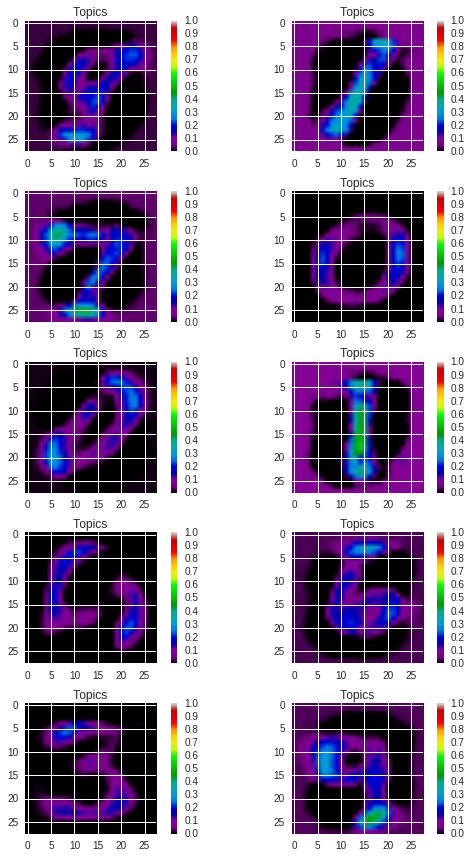

In [16]:
x_sample = vae[3]
plt.figure(figsize=(8, 12))
for i in range(10):

    plt.subplot(5, 2, i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1,cmap='nipy_spectral')
    plt.colorbar()
    plt.title("Topics")
plt.tight_layout()

In [17]:

cost=[]
e1=[]
e2=[]
idx=0
for doc in docs_te:
    idx+=1
    doc = doc.astype('float32')
    n_d = np.sum(doc)
    c,a,b=vae.test(doc)
    cost.append(c/n_d)
    e1.append(a)
    e2.append(b)
    if idx%1000==0:
        print idx
    
# print (np.exp(np.mean(np.array(cost))))
# print np.mean(e1,0)
# print np.mean(e2,0)

1000
2000
3000
4000
5000
6000
7000


In [52]:
with open('nips.txt','w') as o:

    for doc in docs_tr:
        doc_o=[]
        j=-1
        for wc in doc:
            j+=1
            for i in range(int(wc)):
                doc_o.append(vocab[j].strip())
        o.write(" ".join(doc_o)+'\n')

    

In [19]:
pickle.dump(cost,open('cost','w'))
pickle.dump(e1,open('e1','w'))
pickle.dump(e2,open('e2','w'))